# Supervised ML Classifiers for Tanzanian Water-Wells Condition

- **Student  :** Daniel Mwaka
- **Student Pace  :** DSF-FT12
- **Phase :** 3
- **Instructor Name  :** Samuel Karu

## 1 Introduction

Access to clean and reliable water is a fundamental human right and a cornerstone of sustainable development. In many developing nations, including Tanzania, ensuring this access remains a significant challenge. While numerous water points have been established, a substantial portion are in disrepair or have ceased to function altogether, leaving millions without consistent access to this vital resource. The ability to proactively identify and address the issues plaguing these water wells is not just an operational necessity but a critical step towards improving public health, economic stability, and overall quality of life for communities. Understanding the factors that contribute to the failure or disrepair of water infrastructure is therefore paramount, enabling targeted interventions and more effective resource allocation.

In this project, I will leverage a dataset focused on Tanzanian Water Wells, part of an active competition on Kaggle, to address this pressing issue. The dataset is available on https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/.
Using this dataset, the project:

- Examines the features related to water well construction, pump type, installation date, and other relevant information to identify key indicators of well condition.
- Builds a robust classifier model to predict the condition of water wells (functional, in need of repair, or non-functional).
- Determines if the selected features exhibit significant predictive patterns regarding water well operational status.
- Recommends an accurate, reliable, and highly generalizable model that can be deployed by NGOs focused on locating wells in need of repair or the Government of Tanzania in making data-supported decisions on frameworks for designing, and constructing new ground water infrustructure projects.

### 1.1 Problem Statement

The Government of Tanzania and Non-Governmental Organizations (NGOs) face a significant challenge in ensuring reliable access to clean water for their population. A substantial number of established water wells are either in disrepair or have completely failed, leading to water scarcity and its associated negative impacts on public health and socio-economic development. There is currently no effective, data-driven method to accurately predict the condition of water wells, making it difficult to prioritize repair efforts, allocate resources efficiently, and inform the design of new, more resilient water infrastructure. This lack of predictive capability results in reactive maintenance, inefficient resource utilization, and continued widespread water scarcity. The Government of Tanzania and NGOs require a solution that can identify water wells that are in need of repair or are likely to fail, enabling proactive interventions and strategic planning for a sustainable water supply.

### 1.2 Objectives

#### 1.2.1 Goal
To recommend an evidence-based supervised ML classification model for predicting the functional condition of a water well in tanzania.

#### 1.2.2 Specific Objectives
1. Preprocess the dataset justify the predictive power of the data on the target variable.

2. Build, tune, and evaluate the performance of a logistic Regregression model.

3. Build, tune, and evaluate the performance of a Tree-based Classfier.

4. Build, tune, and evaluate the performance of an Ensemble-based Classifier.

5. Compare performance metrics of the three classifier and propose the best alternative for deployment. 


## 2 Exploratory Data Analysis (EDA)
### 2.1 Data Loading and Feature Selection
Load datasets, preliminary feature selection, and data cleaning 

In [65]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [66]:
# Load datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first five rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [68]:
# Drop columns deemed irrelevant to this project
train_df = train_df.drop(columns = ['amount_tsh', 'funder', 'installer', 'latitude', 'longitude', 'scheme_name', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by'])

In [69]:
# Drop redundant columns
train_df = train_df.drop(columns =['scheme_management', 'extraction_type', 'extraction_type_group', 'management', 'payment', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type'])

In [70]:
# Check for duplicate rows in train_df
duplicates = train_df.duplicated()
print(f"Number of duplicate rows in train_df: {duplicates.sum()}")

# Optionally, display duplicate rows
if duplicates.any():
    display(train_df[duplicates])

Number of duplicate rows in train_df: 0


- train_df does not have duplicate entries. 

In [7]:
# Check for missing values
missing = train_df.isnull().sum()
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
missing_df

,Missing Values,Percent
permit,3056,5.144781


In [8]:
train_df['permit'].value_counts()

permit
True     38852
False    17492
Name: count, dtype: int64

- Drop entries with missing values for the `permit` feature to preserve the integrity of train_df. Additionally, dropping entries with nan values for the `permit` column does not a have a significant impact on the size of dataset

In [9]:
# Drop entries with nan values for the `permit` column
train_df = train_df.dropna(subset=['permit'])

In [10]:
# Verify that all selected features dont have missing values
train_df.isna().sum()

id                       0
date_recorded            0
gps_height               0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [11]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 56344 rows
Training dataset consists of: 16 columns


### 2.2 Feature Engineering

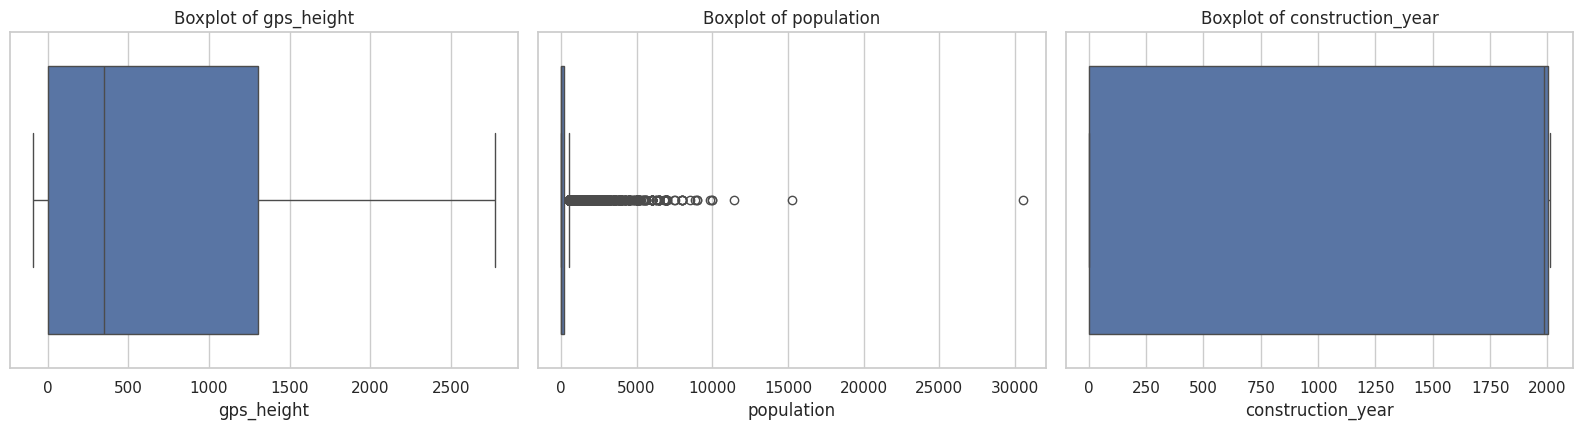

In [12]:
# Define numerical columns (excluding 'id')
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')

# Visualize outliers for selected numerical features using boxplots
plt.figure(figsize=(16, 8))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#### 2.2.1 Engineer `well_age` Feature

A well's age is an important predictor on it condition. Although the feature is not included in the training.csv dataset; it can be engineered by convering the `date_recorded` variable to datetime and substracting the value from a well's construction year.

In [13]:
# Check unique values for `construction_year` feature
train_df['construction_year'].unique()

array([1999, 2010, 2009, 1986,    0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 2007, 1973, 1985, 1995, 2006,
       1962, 2005, 1997, 1970, 1996, 1977, 1983, 2012, 1984, 1982, 1976,
       1988, 1989, 1975, 1960, 1990, 1961, 1998, 1963, 1971, 1994, 1968,
       1980, 1993, 2001, 1979, 1967, 1969, 1981, 2013, 1964, 1966, 1965])

In [14]:
# Drop all row entries with a value of 0 in the column `construction_year`
train_df.drop(train_df[train_df['construction_year'] == 0].index, inplace=True)

In [15]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 36764 rows
Training dataset consists of: 16 columns


In [16]:
# Convert 'date_recorded' to datetime year
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded']).dt.year

# Calculate well_age = date_recorded - construction_year
train_df['well_age'] = train_df['date_recorded'] - train_df['construction_year']

In [17]:
# Confirm the Engineered feature accurately captures a well's age by the date the data was recorded
train_df[['date_recorded', 'construction_year', 'well_age']].head()

,date_recorded,construction_year,well_age
0,2011,1999,12
1,2013,2010,3
2,2013,2009,4
3,2013,1986,27
5,2011,2009,2


In [18]:
 # Drop 'construction_year' and 'date_recorded' features from train_df
train_df = train_df.drop(columns=['construction_year', 'date_recorded'])

In [19]:
train_df['well_age'].describe()

count    36764.000000
mean        15.245186
std         12.467690
min         -7.000000
25%          4.000000
50%         12.000000
75%         25.000000
max         53.000000
Name: well_age, dtype: float64

- The entries with a negative value for the `well-age` feature are not feasible and are dropped from train_df

In [20]:
# Drop all row entries whose values for 'well_age' are less than zero
train_df = train_df[train_df['well_age'] >= 0]

#### 2.2.2 Multicollinearity Check
- Highly correlated numerical features leads to multicolinearity. Training supervised ML classifiers with highly correlated numerical features increases computational complexity, and elevates the risk for overfitting. 
- Additionally, multicollinearity leads to uncertainity in determining the true contribuction of each feature to predictions.
- Correlation measures are highly sensitive to outliers.

In [21]:
# Identify numerical columns after engineering features
num_cols_1 = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_1.remove('id')

# Remove outliers
for col in num_cols_1:
    lower = train_df[col].quantile(0.01)
    upper = train_df[col].quantile(0.99)
    train_df = train_df[(train_df[col] >= lower) & (train_df[col] <= upper)]


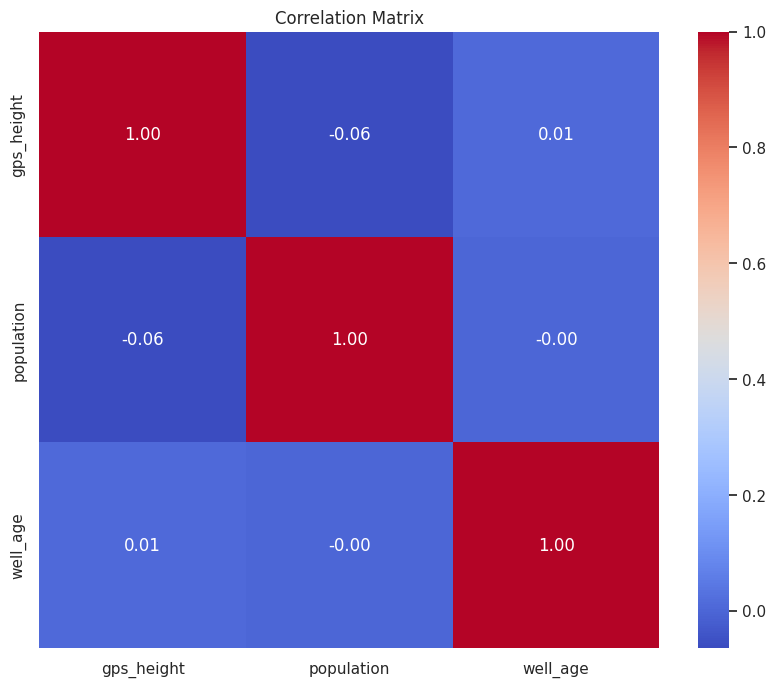

In [22]:
# Plot the correlation matrix
corr = train_df[num_cols_1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- There is no multicolineariry among the numerical variables. 
- For inclusion alongside the OneHotEncoded categorical features; these numerical variables must be standardized. 
- The MinMaxScaller is selected because it scales numerical features between 0 and 1. Hence, the scaled numerical features will lie within the same range as the OneHotEncoded dummy variables for categorical features. 

In [23]:
scaler = MinMaxScaler()
train_df[num_cols_1] = scaler.fit_transform(train_df[num_cols_1])

#### 2.2.3 Label-Encoding The Target variable and OneHot-Encoding Categorical Features

In [24]:
# Encode target variable and Feature Engineer its name
le = LabelEncoder()
train_df['status_group_encoded'] = le.fit_transform(train_df['status_group'])

In [25]:
# Define categorical features
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')
    

In [26]:
cat_cols

['basin',
 'region',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type_group']

In [27]:
# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_features = ohe.fit_transform(train_df[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)
cat_df = pd.DataFrame(cat_features, columns=cat_feature_names, index=train_df.index)

# Concatenate one-hot encoded features with the rest of the DataFrame
train_df_encoded = pd.concat([
    train_df.drop(columns=cat_cols),
    cat_df
], axis=1)

In [28]:
train_df_encoded.head()

,id,gps_height,population,status_group,well_age,status_group_encoded,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,0.642306,0.045417,functional,0.272727,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,8776,0.646391,0.116667,functional,0.068182,0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,34310,0.322742,0.104167,functional,0.090909,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,67743,0.130731,0.024167,non functional,0.613636,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,9944,0.011348,0.000417,functional,0.045455,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
# Check shape
train_df_encoded.shape
print(f"Training dataset consists of: {train_df_encoded.shape[0]} rows")
print(f"Training dataset consists of: {train_df_encoded.shape[1]} columns")

Training dataset consists of: 35327 rows
Training dataset consists of: 69 columns


#### 2.2.4 Define Exog, Endog, and Train-Test Split

In [30]:
# Split data into features and target
y = train_df_encoded['status_group_encoded']
X = train_df_encoded.drop(['id', 'status_group', 'status_group_encoded'], axis=1)

In [31]:
# Perform a Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3 Addressing Class Imbalance

Before building supervised machine learning models; the class distribuction of the target variable for the training set must be balanced to optimize the performance of the model to minimize biase towards the majority class. Training ML classifiers on an unbalanced data can result to a model that performs exceptionally well in making predictions for the majority class but poorly for the minority classes. 

Additionally, it compromises the legibility of standard evaluation measures when comparing the performance of different models to determine the best fit/ most appropriate alternative respective to a specific business problem. For instance, the accuracy metrics can be deceptive since a model's score is skewed upwards if it is able to make accurate predictions for the majority class even if it performs poorly in predicting the minority class. 

Thus, to guarantee that the recommended model will generalize well once it is deployed; it is mandatory to balance the training set. Training the supervised machine learning classifiers on a balanced train set optimizes the projects effectiveness and reliability in:
- Making predictions on wells most likely in need of repair.
- Shedding insight on how to schedule maintenance routines.
- Finding patterns on the key factors that have a substantial impact on the long-term functionality of a water-well.  



Class distribution in training set:
status_group_encoded
0    15962
2    10501
1     1798
Name: count, dtype: int64


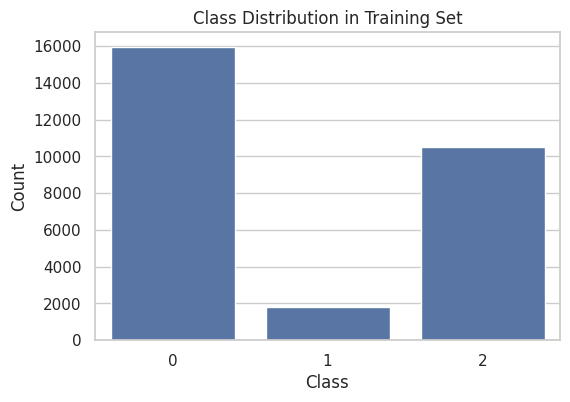

In [32]:
# Check class balance
class_counts = y_train.value_counts()
print("Class distribution in training set:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

To ensure that integrity of the training dataset is maintained; the majority classes are undersampled to match the number of samples in the minority class. The undersampling technique is deemed appropriate because the minority class 1 (Functional but needs repair) has 1798 samples. Thus undersampling class 0 (Funtional) and class 2 (Non Functional) to match class 1's samples will not result in significant information loss. In contrast, adopting other strategies such as SMOTE on the minority class would have substantial impact on the authenticity of the training set. Oversampling the minority class also elevates the risk for overfitting since its samples are substantially small compared to class O (15962 samples), and class 2 (10962 samples).  

In [33]:
# Randomly undersampling class 0 and class 2 to match class 1 in the training set

from collections import Counter
from sklearn.utils import resample

# Get class distribution
class_counts = y_train.value_counts()
print("Class distribution in training set before undersampling:")
print(class_counts)

# Find the minority class count (class 1)
min_class_count = class_counts.min()

# Separate each class
Xy_train = X_train.copy()
Xy_train['target'] = y_train

# Undersample class 0
class_0 = Xy_train[Xy_train['target'] == 0]
class_1 = Xy_train[Xy_train['target'] == 1]
class_2 = Xy_train[Xy_train['target'] == 2]

class_0_down = resample(class_0, replace=False, n_samples=min_class_count, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=min_class_count, random_state=42)

# Combine undersampled classes
Xy_balanced = pd.concat([class_0_down, class_1, class_2_down])
Xy_balanced = Xy_balanced.sample(frac=1, random_state=42)  

X_train_bal = Xy_balanced.drop('target', axis=1)
y_train_bal = Xy_balanced['target']

print("Class distribution in training set after random undersampling:")
print(y_train_bal.value_counts())

Class distribution in training set before undersampling:
status_group_encoded
0    15962
2    10501
1     1798
Name: count, dtype: int64
Class distribution in training set after random undersampling:
target
1    1798
0    1798
2    1798
Name: count, dtype: int64


In [34]:
# Export preprocessed data for Tableau
export_df = X_train_bal.copy()
export_df['status_group'] = le.inverse_transform(y_train_bal)
export_df.to_csv('./data/water-wells-data.csv', index=False)
print("Preprocessed data exported to 'water-wells-data.csv'.")

Preprocessed data exported to 'water-wells-data.csv'.


## 3 Modelling 

### 3.1 Logistic Regression Model

Build a simple supervised classification model (Logistic Regression), evaluate its performance, and discuss its limitations. The simple model is tuned to re-evaluate performance before proceeding on to build alternative classification models.

#### 3.1.1 Untuned Logistic Regression Model

In [35]:
# Build and Evaluate a Simple Model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Train simple model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=1000, random_state=42)

In [36]:
# Predict the target on the train set
y_pred_train = logreg.predict(X_train)
y_proba_train = logreg.predict_proba(X_train)

# Predict the target on the test set
y_pred_test = logreg.predict(X_test)
y_proba_test = logreg.predict_proba(X_test)

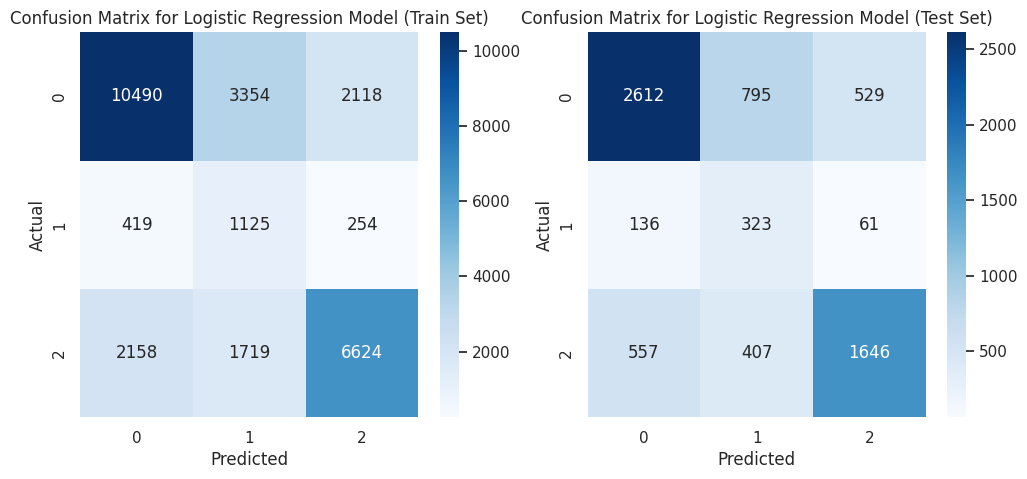

In [37]:
# Plot confusion matrices for logistic regression model on both train and test sets 
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot Confusion Matrix for model performance on train Set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Logistic Regression Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-untuned-logistic-regression-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

Shape of y_train_bin: (28261, 3)
Shape of y_test_bin: (7066, 3)


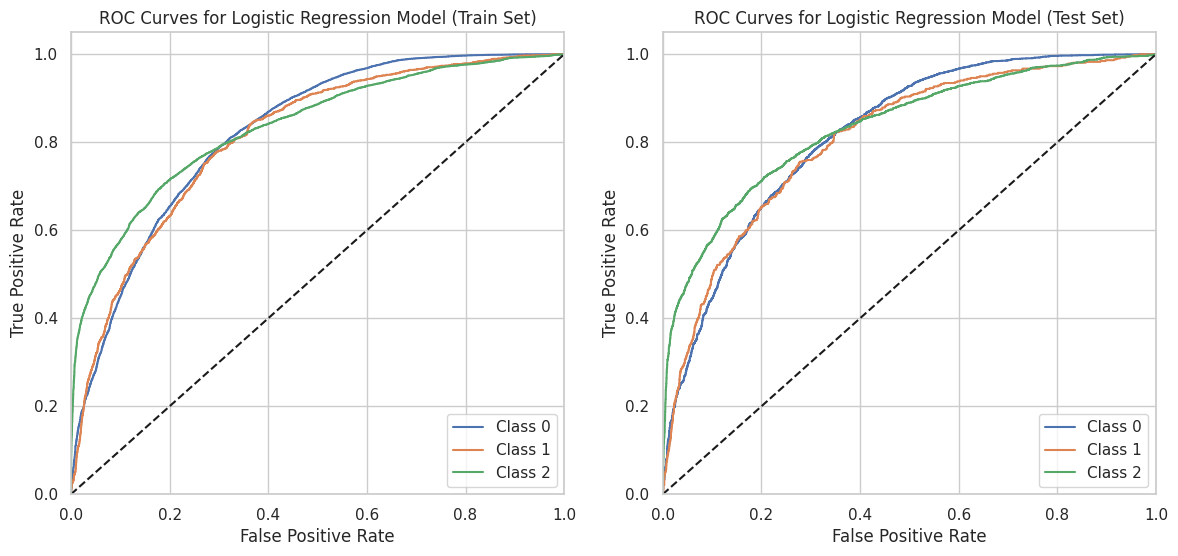

In [38]:
# Plot ROC curves for logistic regression model on both train and test sets
from sklearn.preprocessing import label_binarize

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize the true labels for each class
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

# Plot ROC curve for model performance on train set                            
y_train_bin = label_binarize(y_train, classes=range(n_classes))
print(f"Shape of y_train_bin: {y_train_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--') 
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Logistic Regression Model (Train Set)')
axes[0].legend(loc='lower right')
axes[0].grid(True) 
axes[0].set_xlim([0.0, 1.0]) 
axes[0].set_ylim([0.0, 1.05]) 

# Plot  ROC curve for model performance on test set
# Binarize the true labels for each class
y_test_bin = label_binarize(y_test, classes=range(n_classes))
print(f"Shape of y_test_bin: {y_test_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--') 
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Logistic Regression Model (Test Set)')
axes[1].legend(loc='lower right') 
axes[1].grid(True) 
axes[1].set_xlim([0.0, 1.0]) 
axes[1].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-untuned-logistic-regression-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.1.2 Tuned Logistic Regression Model

In [39]:
# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
print(f"Best parameters: {gs.best_params_}")

Best parameters: {'C': 100}


In [40]:
# Predict on train and test sets
y_pred_gs_train = gs.predict(X_train)
y_proba_gs_train = gs.predict_proba(X_train)
y_pred_gs = gs.predict(X_test)
y_proba_gs = gs.predict_proba(X_test)

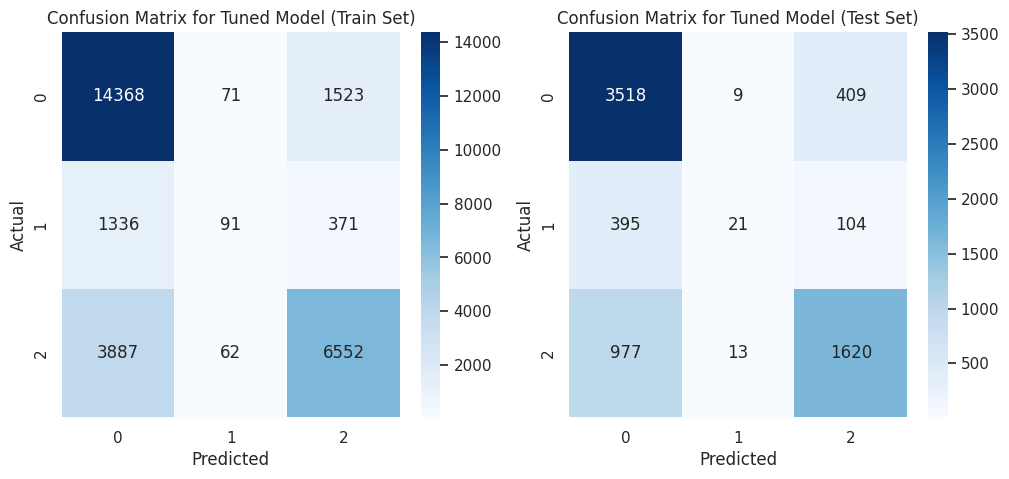

In [41]:
# Plot confusion matrices for logistic regression model performance on both train and test sets 
cm_test = confusion_matrix(y_test, y_pred_gs)
cm_train = confusion_matrix(y_train, y_pred_gs_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix for model performance on test set 
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Tuned Model (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on train set 
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Tuned Model (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-tuned-logistic-regression-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

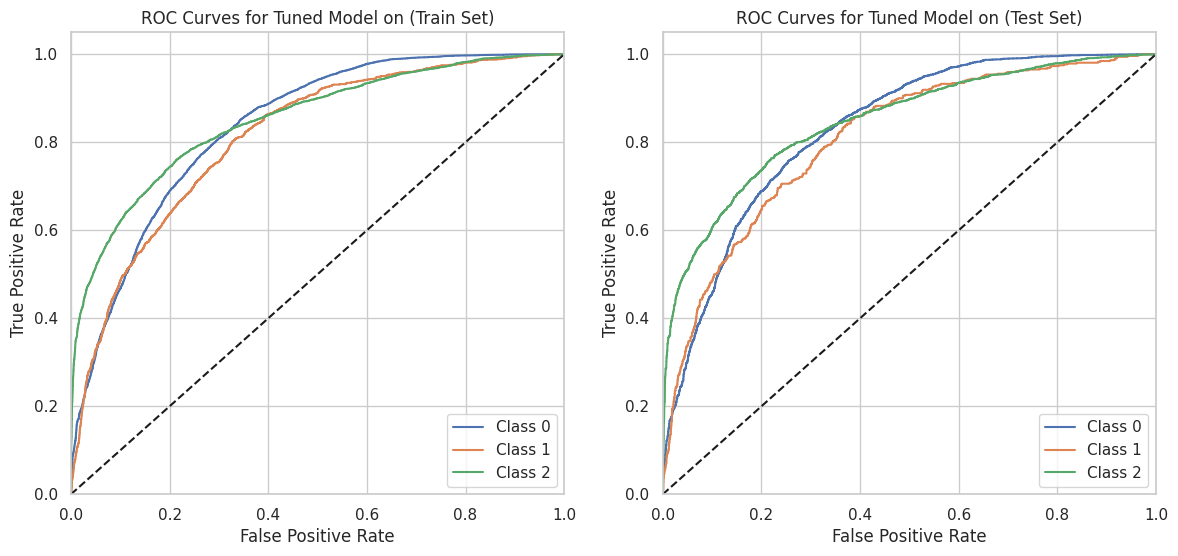

In [42]:
# Plot ROC curves for tuned logistic regression model on both train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize y_test to match the structure needed by roc_curve for multiclass
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

y_test_bin = label_binarize(y_test, classes=range(n_classes))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves for Tuned Model on (Test Set)')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])


# Binarize y_train to match the structure needed by roc_curve for multiclass
y_train_bin = label_binarize(y_train, classes=range(n_classes)) 
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gs_train[:, i]) 
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves for Tuned Model on (Train Set)') 
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

plt.savefig("./images/roc-curves-tuned-logistic-regression-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

In [43]:
# Evaluate performance on train set for untuned model
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, average='weighted')
rec_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')
roc_auc_train = roc_auc_score(y_train, y_proba_train, multi_class='ovr')

# Evaluate performance on test set for untuned model
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='weighted')
rec_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
roc_auc_test = roc_auc_score(y_test, y_proba_test, multi_class='ovr')

# Evaluate performance on train set for tuned model
acc_gs_train = accuracy_score(y_train, y_pred_gs_train)
prec_gs_train = precision_score(y_train, y_pred_gs_train, average='weighted')
rec_gs_train = recall_score(y_train, y_pred_gs_train, average='weighted')
f1_gs_train = f1_score(y_train, y_pred_gs_train, average='weighted')
roc_auc_gs_train = roc_auc_score(y_train, y_proba_gs_train, multi_class='ovr')

# Evaluate performance on test set for tuned model
acc_gs = accuracy_score(y_test, y_pred_gs)
prec_gs = precision_score(y_test, y_pred_gs, average='weighted')
rec_gs = recall_score(y_test, y_pred_gs, average='weighted')
f1_gs = f1_score(y_test, y_pred_gs, average='weighted')
roc_auc_gs = roc_auc_score(y_test, y_proba_gs, multi_class='ovr')

# Create a DataFrame with metrics for both untuned and tuned Logistic Regression
metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_train, acc_gs_train],
    'Test Accuracy': [acc_test, acc_gs],
    'Train Precision': [prec_train, prec_gs_train],
    'Test Precision': [prec_test, prec_gs],
    'Train Recall': [rec_train, rec_gs_train

],
    'Test Recall': [rec_test, rec_gs],
    'Train F1-score': [f1_train, f1_gs_train],
    'Test F1-score': [f1_test, f1_gs],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs]
})

# Set the index to 'Model'
metrics_df.set_index('Model', inplace=True)

metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.645377,0.648316,0.738565,0.727730,0.645377,0.648316,0.678582,0.676042,0.822257,0.820428
Tuned Model,0.743463,0.730116,0.728322,0.717223,0.743463,0.730116,0.719220,0.701876,0.832357,0.828832


#### 3.1.3 Model Performance Comparison: Untuned vs. Tuned Logistic Regression

- The untuned Logistic Regression model achieved an F1-score of approximately 0.68 on both the training and test set, with an accuracy of about 65% on both sets. The ROC-AUC score is about 82% on (train) and (test).
- After hyperparameter tuning, the Logistic Regression model showed a slight improvement, with the F1-score increasing to 0.72 (train) and 0.70 (test). The accuracy improved to 74% (train) and increased to 73% on test set. The ROC-AUC score improved to 83% on (train) and (test), indicating the tuned model's better overall discrimination between classes.
- Although the tuned model shows an improvement in the f1-score and accuracy; the Logistic Regression may have reached its capacity for this dataset. Additionally, the confusion matrices substantiate the Logistic Regression model's limitations. 

**Limitation:** Logistic Regression is limited in capturing interactions between features when fitting complex datasets since its approach framework tries to separate classes using hyperplanes. To address these limitations, it is necessary to build a Decision Tree Classifier model. Tree-based classifiers can model non-linear relationships and feature interactions more effectively, potentially improving classification performance, especially for classes that are harder to separate leveraging hyperplanes. The next section models a Decision Tree Classifier. 

### 3.2 Tree-Based Classification Model

A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It works by recursively splitting the dataset into subsets based on the value of input features, forming a tree-like structure of decisions. Each internal node represents a decision based on a feature, each branch represents the outcome of that decision, and each leaf node represents a class label (prediction).

Decision Trees can capture non-linear relationships and interactions between features without requiring explicit feature engineering. They can model complex decision boundaries by splitting the data multiple times based on different features and thresholds. This flexibility allows Decision Trees to potentially achieve better predictive performance than Logistic Regression, especially when the underlying patterns in the data are not well-approximated by linear models. Hence, Decision Tree Classifiers have substantial potential to outperform the Logistic Regression model in a ternary classification problem.

#### 3.2.1 Untuned Decision Tree Classifier

In [44]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(random_state=42)

In [45]:
# Predict for train and test set
y_pred_dt_train = dt.predict(X_train)
y_proba_dt_train = dt.predict_proba(X_train)
y_pred_dt_test = dt.predict(X_test)
y_proba_dt_test = dt.predict_proba(X_test)

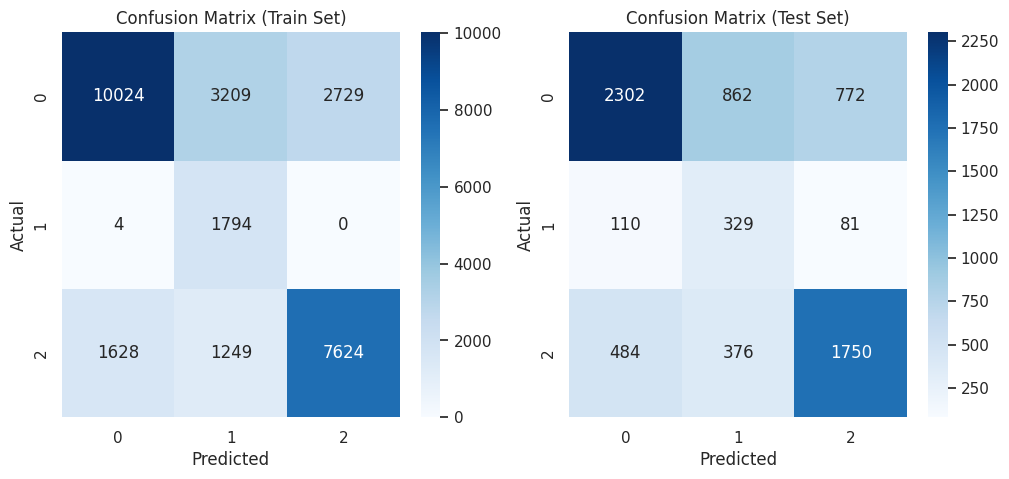

In [46]:
# Confusion matrices for Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train, y_pred_dt_train)
cm_test = confusion_matrix(y_test, y_pred_dt_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-untuned-decision-tree-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

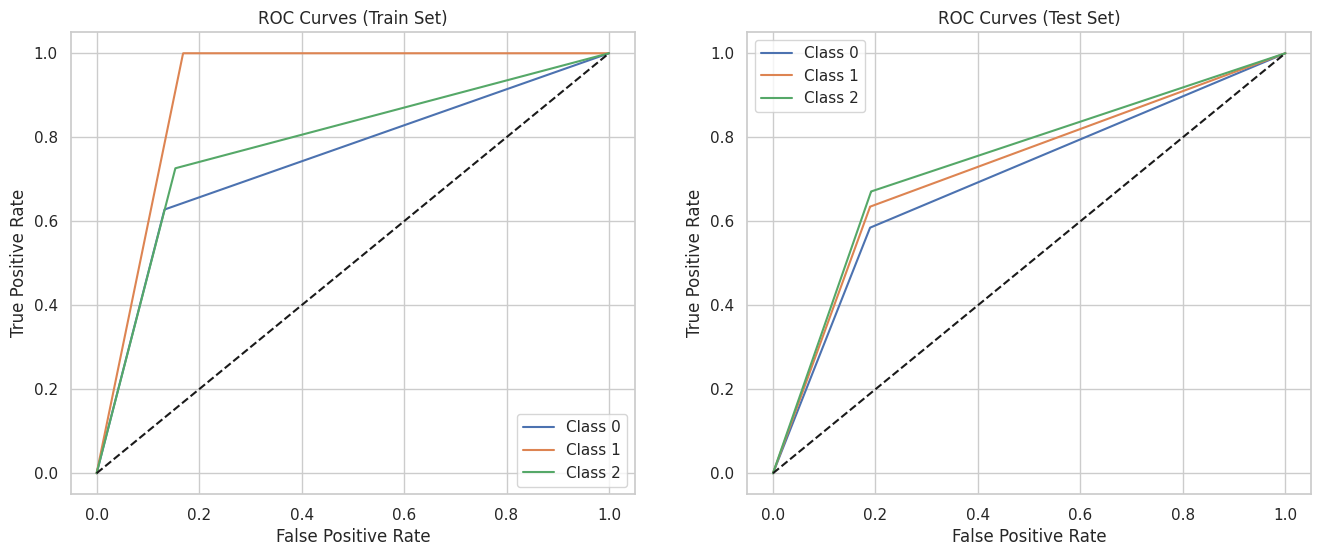

In [47]:
# ROC Curves for Untuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-untuned-decision-tree-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.2.2 Tuned Decision Tree Classifier

In [48]:
# Hyperparameter tuning for Decision Tree Classifier 
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, criterion='gini'), param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
gs_dt.fit(X_train_bal, y_train_bal)
print(f"Best Decision Tree params: {gs_dt.best_params_}")

Best Decision Tree params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [49]:
# Predict on train and test sets
y_pred_dt_gs_train = gs_dt.predict(X_train)
y_proba_dt_gs_train = gs_dt.predict_proba(X_train)
y_pred_dt_gs = gs_dt.predict(X_test)
y_proba_dt_gs = gs_dt.predict_proba(X_test)

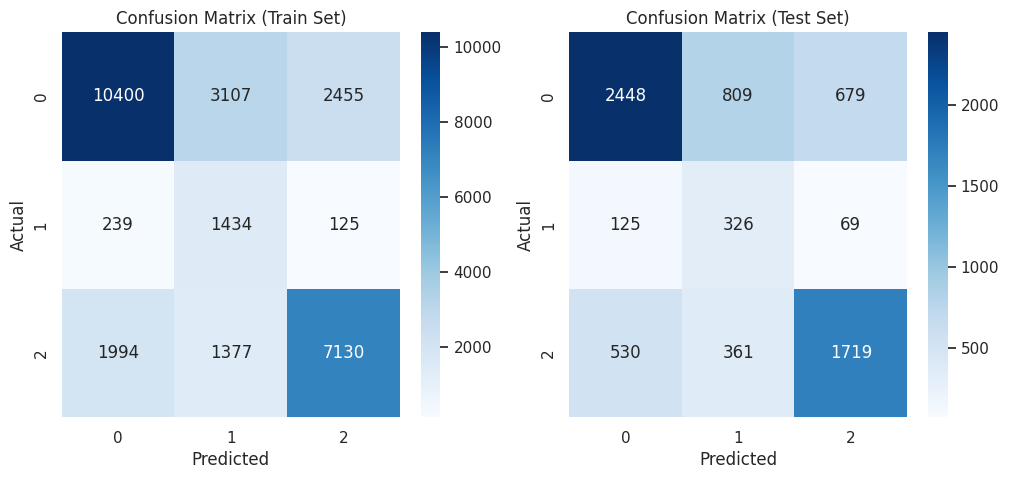

In [50]:
# Confusion matrices for Tuned Decision Tree Classifier in prediciting for both train and test sets
cm_train = confusion_matrix(y_train, y_pred_dt_gs_train)
cm_test = confusion_matrix(y_test, y_pred_dt_gs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion_matrices-tuned-decision-tree-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

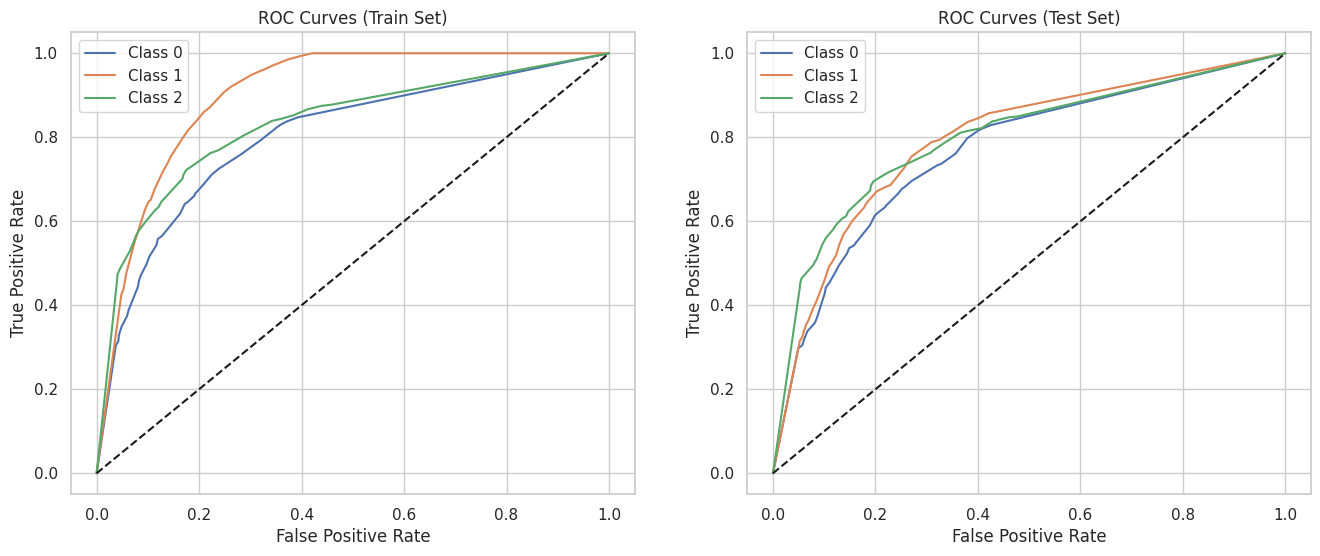

In [51]:
# ROC Curves for Tuned Decision Tree Classifier in predicitng both train and test sets
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves for untuned Decision Tree Classifier on Train Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_dt_gs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()

# ROC Curves for Untuned Decision Tree Classifier on Test Set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()

plt.savefig("./images/roc-curves-tuned-decision-tree-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

In [52]:
# Compute metrics for Untuned Decision Tree Classifier
acc_dt_train = accuracy_score(y_train, y_pred_dt_train)
prec_dt_train = precision_score(y_train, y_pred_dt_train, average='weighted')
rec_dt_train = recall_score(y_train, y_pred_dt_train, average='weighted')
f1_dt_train = f1_score(y_train, y_pred_dt_train, average='weighted')
roc_auc_dt_train = roc_auc_score(y_train, y_proba_dt_train, multi_class='ovr')

acc_dt_test = accuracy_score(y_test, y_pred_dt_test)
prec_dt_test = precision_score(y_test, y_pred_dt_test, average='weighted')
rec_dt_test = recall_score(y_test, y_pred_dt_test, average='weighted')
f1_dt_test = f1_score(y_test, y_pred_dt_test, average='weighted')
roc_auc_dt_test = roc_auc_score(y_test, y_proba_dt_test, multi_class='ovr')

# Compute metrics for Tuned Decision Tree Classifier
acc_dt_gs_train = accuracy_score(y_train, y_pred_dt_gs_train)
prec_dt_gs_train = precision_score(y_train, y_pred_dt_gs_train, average='weighted')
rec_dt_gs_train = recall_score(y_train, y_pred_dt_gs_train, average='weighted')
f1_dt_gs_train = f1_score(y_train, y_pred_dt_gs_train, average='weighted')
roc_auc_dt_gs_train = roc_auc_score(y_train, y_proba_dt_gs_train, multi_class='ovr')

acc_dt_gs_test = accuracy_score(y_test, y_pred_dt_gs)
prec_dt_gs_test = precision_score(y_test, y_pred_dt_gs, average='weighted')
rec_dt_gs_test = recall_score(y_test, y_pred_dt_gs, average='weighted')
f1_dt_gs_test = f1_score(y_test, y_pred_dt_gs, average='weighted')
roc_auc_dt_gs_test = roc_auc_score(y_test, y_proba_dt_gs, multi_class='ovr')

# Create DataFrame with metrics
dt_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_dt_train, acc_dt_gs_train],
    'Test Accuracy': [acc_dt_test, acc_dt_gs_test],
    'Train Precision': [prec_dt_train, prec_dt_gs_train],
    'Test Precision': [prec_dt_test, prec_dt_gs_test],
    'Train Recall': [rec_dt_train, rec_dt_gs_train],
    'Test Recall': [rec_dt_test, rec_dt_gs_test],
    'Train F1-score': [f1_dt_train, f1_dt_gs_train],
    'Test F1-score': [f1_dt_test, f1_dt_gs_test],
    'Train ROC-AUC': [roc_auc_dt_train, roc_auc_dt_gs_train],
    'Test ROC-AUC': [roc_auc_dt_test, roc_auc_dt_gs_test]
})

# Set the index to 'Model'
dt_metrics_df.set_index('Model', inplace=True)

dt_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.687945,0.620011,0.777609,0.706562,0.687945,0.620011,0.710038,0.646578,0.816522,0.719962
Tuned Model,0.671031,0.635862,0.753231,0.712868,0.671031,0.635862,0.696653,0.661377,0.844391,0.786505


#### 3.2.3 Model Performance Interpretation: Untuned vs. Tuned Decision Tree

- The untuned Decision Tree classifier achieved an F1-score of approximately 0.71 on the training set and 0.65 on the test set, with accuracy around 49% (train) and 62% (test). The ROC-AUC score (train) is around 0.82 and 0.72 (test).
- After hyperparameter tuning, the Decision Tree's F1-score (train) set did not improve. The f1-score improved slightly to 0.66. The accuracy showed no significant improvement on (train) but increased slightly on the test set. The ROC-AUC score (train) increased to 0.84 and ROC-AUC (test) improved to 0.78, indicating the tuned model's better class discrimination. 
- However, both the untuned and the tuned Decision Tree classifier modles show a substantial gap between training and test performance metrics. This disparity alludes to potential overfitting.
- While the tuned Decision Tree Classifier performs better; its f1-score and accuracy metrics lag the tuned Logistic Regression model in terms of generalization, especially on the test set.
- Additionally, the confusion matrices indicate that certain classes are still misclassified at a notable rate, and the model may struggle with minority classes.

**Limitations:** Decision Trees can easily overfit the training data, especially with many features or when the tree is deep, leading to poor generalization. Small changes in the data can result in very different tree structures, making the model less robust. Additionally, a single tree may not capture complex, non-linear relationships as effectively as ensemble methods. Thus, building a Gradient Boosting Classifier is necessary to achieve higher accuracy, better generalization, and improved performance on all classes in this ternary classification problem. It addresses the limitations of single decision trees and is widely regarded as a state-of-the-art approach for structured tabular data.

### 3.3 Ensemble-Based Classification Model

A Gradient Boosting Classifiers fits a number of randomized decision trees on various sub-samples of the training dataset and uses averaging to improve the predictive accuracy and control over-fitting. A Gradient Boosting Classifier is an ensemble method since the modelled decision trees are build sequentially. Each new tree in the sequence is trained to correct the errors made by the sum of previously built trees. Such an iterative error-correction process gradually improves the model's overall performance, reduces bias and minimizes variance across the model's predictions. Thus, building a Gradient Boosting Classifier is necessary since ensemble models:
- Reduce overfitting by combining multiple trees and using regularization.
- Improve predictive accuracy, especially for complex, non-linear relationships.
- Handle class imbalance and minority class prediction better through boosting.
- Are more robust and stable than a single decision tree.


#### 3.3.1 Untuned Gradient Boosting Classifier

In [53]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting on balanced data
gb_bal = GradientBoostingClassifier(random_state=42)
gb_bal.fit(X_train_bal, y_train_bal)

GradientBoostingClassifier(random_state=42)

In [54]:
# Predict on train and test sets 
y_pred_gb_train = gb_bal.predict(X_train)
y_proba_gb_train = gb_bal.predict_proba(X_train)
y_pred_gb_test = gb_bal.predict(X_test)
y_proba_gb_test = gb_bal.predict_proba(X_test)


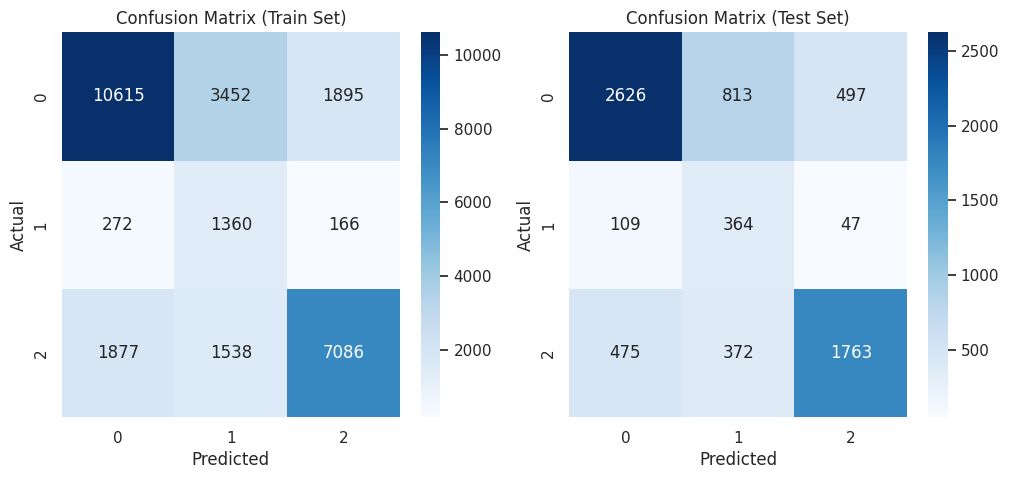

In [55]:
# Plot confusion matrices for Gradient Boosting Classifier on both train and test sets
cm_gb_train = confusion_matrix(y_train, y_pred_gb_train)
cm_gb_test = confusion_matrix(y_test, y_pred_gb_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set confusion matrix
sns.heatmap(cm_gb_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test set confusion matrix
sns.heatmap(cm_gb_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-untuned-gradient-boosting-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

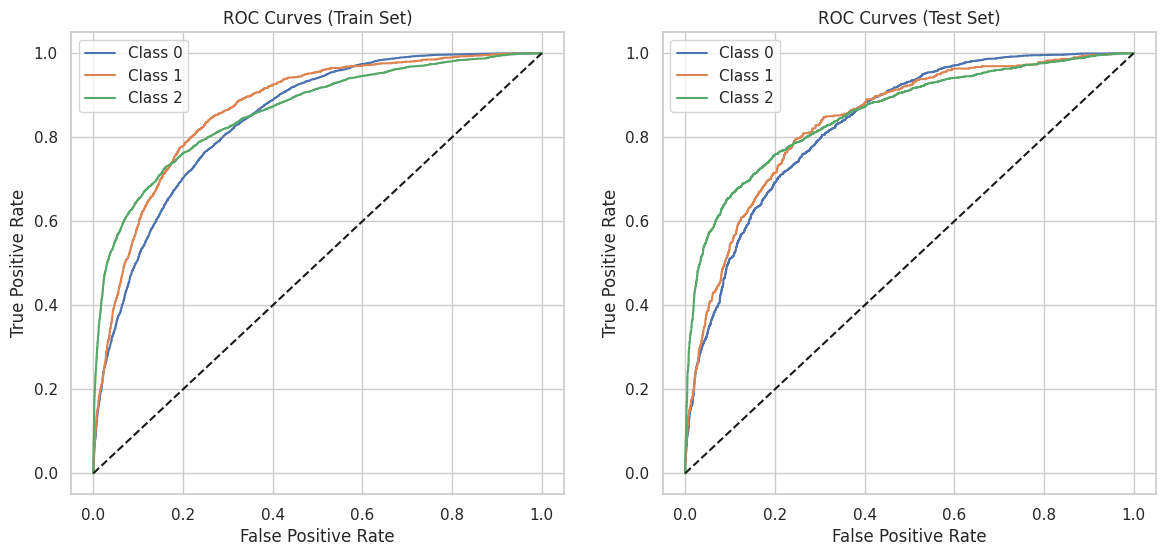

In [56]:
from sklearn.preprocessing import label_binarize

# Plot ROC curves for Gradient Boosting Classifier on both train and test sets

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Binarize the true labels for multiclass ROC
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-untuned-gradient-boosting-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

#### 3.3.2 Tuned Gradient Boosting Classifier

In [57]:
# Define parameter grid for tuning
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit on balanced training data
gs_gb.fit(X_train_bal, y_train_bal)
print(f"Best Gradient Boosting params: {gs_gb.best_params_}")

Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [58]:
# Predict on train and test sets
y_pred_gb_rs_train = gs_gb.predict(X_train)
y_proba_gb_rs_train = gs_gb.predict_proba(X_train)
y_pred_gb_rs = gs_gb.predict(X_test)
y_proba_gb_rs = gs_gb.predict_proba(X_test)

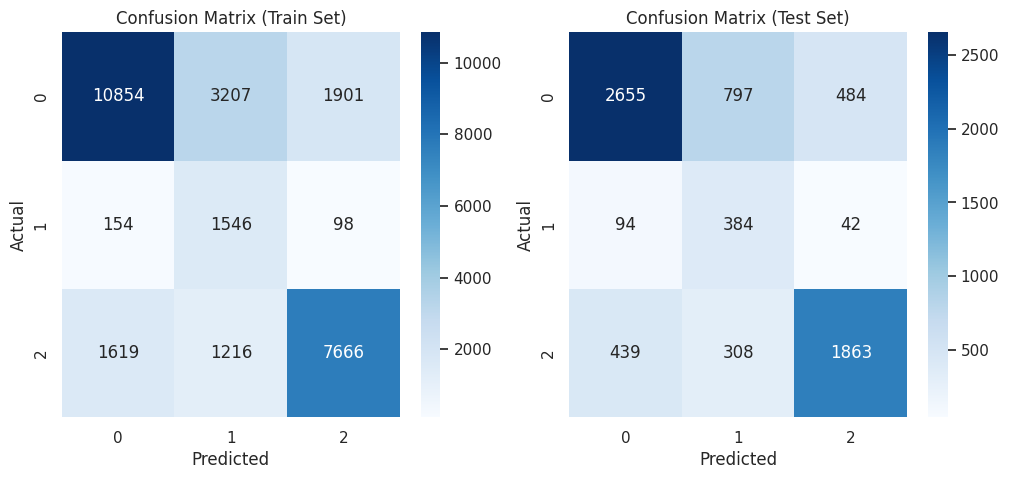

In [59]:
# Plot confusion matrices for the tuned model's performance on train and test sets, side by side
cm_train = confusion_matrix(y_train, y_pred_gb_rs_train)
cm_test = confusion_matrix(y_test, y_pred_gb_rs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Train Set)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test set confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.savefig("./images/confusion-matrices-tuned-gradient-boosting-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

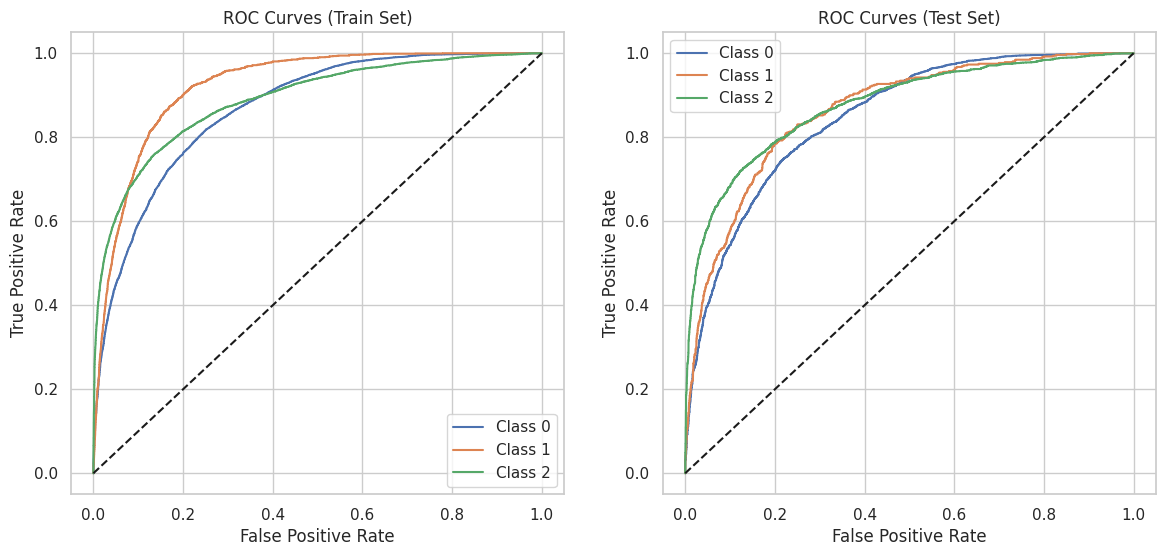

In [60]:
# Plot ROC curves for the tuned Gradient Boosting model on both train and test sets, side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC curves for train set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gb_rs_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Train Set)')
axes[0].legend()
axes[0].grid(True)

# ROC curves for test set
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb_rs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Test Set)')
axes[1].legend()
axes[1].grid(True)

plt.savefig("./images/roc-curves-tuned-gradient-boosting-classifier.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()


In [61]:
# Compute performance metrics for untuned Gradient Boosting Classifier
acc_gb_train = accuracy_score(y_train, y_pred_gb_train)
prec_gb_train = precision_score(y_train, y_pred_gb_train, average='weighted')
rec_gb_train = recall_score(y_train, y_pred_gb_train, average='weighted')
f1_gb_train = f1_score(y_train, y_pred_gb_train, average='weighted')
roc_auc_gb_train = roc_auc_score(y_train, y_proba_gb_train, multi_class='ovr')

acc_gb_test = accuracy_score(y_test, y_pred_gb_test)
prec_gb_test = precision_score(y_test, y_pred_gb_test, average='weighted')
rec_gb_test = recall_score(y_test, y_pred_gb_test, average='weighted')
f1_gb_test = f1_score(y_test, y_pred_gb_test, average='weighted')
roc_auc_gb_test = roc_auc_score(y_test, y_proba_gb_test, multi_class='ovr')

# Compute performance metrics for tuned Gradient Boosting Classifier
acc_gb_rs_train = accuracy_score(y_train, y_pred_gb_rs_train)
prec_gb_rs_train = precision_score(y_train, y_pred_gb_rs_train, average='weighted')
rec_gb_rs_train = recall_score(y_train, y_pred_gb_rs_train, average='weighted')
f1_gb_rs_train = f1_score(y_train, y_pred_gb_rs_train, average='weighted')
roc_auc_gb_rs_train = roc_auc_score(y_train, y_proba_gb_rs_train, multi_class='ovr')

acc_gb_rs_test = accuracy_score(y_test, y_pred_gb_rs)
prec_gb_rs_test = precision_score(y_test, y_pred_gb_rs, average='weighted')
rec_gb_rs_test = recall_score(y_test, y_pred_gb_rs, average='weighted')
f1_gb_rs_test = f1_score(y_test, y_pred_gb_rs, average='weighted')
roc_auc_gb_rs_test = roc_auc_score(y_test, y_proba_gb_rs, multi_class='ovr')

# Create DataFrame with metrics
gb_metrics_df = pd.DataFrame({
    'Model': ['Untuned Model', 'Tuned Model'],
    'Train Accuracy': [acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_gb_test, rec_gb_rs_test],
    'Train F1-score': [f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Set the index to 'Model'
gb_metrics_df.set_index('Model', inplace=True)

gb_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Untuned Model,0.674463,0.672658,0.771189,0.755260,0.674463,0.672658,0.706673,0.700170,0.856597,0.844380
Tuned Model,0.710024,0.693745,0.796699,0.770929,0.710024,0.693745,0.736695,0.718641,0.893489,0.862881


#### 3.3.3 Model Performance Interpretation: Untuned vs. Tuned Gradient Boosting Classifier

The tuned Gradient Boosting Classifier outperforms the untuned version across all metrics on both the training and test sets.

- **F1-score:** Untuned model achieves 0.71 (train) and 0.70 (test), while the tuned model improves to 0.74 (train) and 0.72 (test), indicating better balance between precision and recall after tuning.

- **Accuracy:** Untuned model has 67% (train/test), tuned model increases to 71% (train) and 69% (test).

- **Precision & Recall:** Both metrics are higher for the tuned model, showing improved ability to correctly identify all classes.
- **ROC-AUC:** Tuned model achieves 0.89 (train) and 0.86 (test), compared to 0.86 (train) and 0.84 (test) for the untuned model, indicating better overall class discrimination.

## 4 Best Supervised ML Classifier

### 4.1 Select Deployment Model
This section compares the respective performance metrics (Accuracy, Precision, Recall, F1-score, and ROC-AUC) for all models (untuned and tuned). The insights deduced from these comparisons are vital in supporting data-driven decisions on the best-fit/ most-appropriate supervised ML classifier for deployment. The best model based on performance metrics and generalizability insights is selected for deployment for utilization in predicting the functional status of a Tanzanian water well. Highly accurate predictions are crucial in optimizing the operational effectiveness of NGO's focused on locating wells in need of maintenance/ repairs. Additionally, a generalizable model will support the Tanzanian Government in extrapolating patterns for non-functional wells to make better-informed, data-supported decisions on the framework for designing, planning, and implementing new ground water infrustructure. 

In [62]:
# Compare the performance for all the models (tuned and untuned classifiers)
all_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression (Untuned)', 
              'Logistic Regression (Tuned)', 
              'Decision Tree (Untuned)', 
              'Decision Tree (Tuned)', 
              'Gradient Boosting (Untuned)', 
              'Gradient Boosting (Tuned)'],
    'Train Accuracy': [acc_train, acc_gs_train, acc_dt_train, acc_dt_gs_train, acc_gb_train, acc_gb_rs_train],
    'Test Accuracy': [acc_test, acc_gs, acc_dt_test, acc_dt_gs_test, acc_gb_test, acc_gb_rs_test],
    'Train Precision': [prec_train, prec_gs_train, prec_dt_train, prec_dt_gs_train, prec_gb_train, prec_gb_rs_train],
    'Test Precision': [prec_test, prec_gs, prec_dt_test, prec_dt_gs_test, prec_gb_test, prec_gb_rs_test],
    'Train Recall': [rec_train, rec_gs_train, rec_dt_train, rec_dt_gs_train, rec_gb_train, rec_gb_rs_train],
    'Test Recall': [rec_test, rec_gs, rec_dt_test, rec_dt_gs_test, rec_gb_test, acc_gb_rs_test],
    'Train F1-score': [f1_train, f1_gs_train, f1_dt_train, f1_dt_gs_train, f1_gb_train, f1_gb_rs_train],
    'Test F1-score': [f1_test, f1_gs, f1_dt_test, f1_dt_gs_test, f1_gb_test, f1_gb_rs_test],
    'Train ROC-AUC': [roc_auc_train, roc_auc_gs_train, roc_auc_dt_train, roc_auc_dt_gs_train, roc_auc_gb_train, roc_auc_gb_rs_train],
    'Test ROC-AUC': [roc_auc_test, roc_auc_gs, roc_auc_dt_test, roc_auc_dt_gs_test, roc_auc_gb_test, roc_auc_gb_rs_test]
})

# Calculate cumulative score across all metrics for each model
all_metrics_df['Cumulative Score'] = all_metrics_df[['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 
                                                    'Train Recall', 'Test Recall', 'Train F1-score', 'Test F1-score', 
                                                    'Train ROC-AUC', 'Test ROC-AUC']].sum(axis=1)

# Sort by cumulative score in descending order
all_metrics_df = all_metrics_df.sort_values(by='Cumulative Score', ascending=False)

# Set the index to 'Model' and drop the Cumulative Score column for display
all_metrics_df.set_index('Model', inplace=True)
all_metrics_df = all_metrics_df.drop(columns=['Cumulative Score'])
all_metrics_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,Train ROC-AUC,Test ROC-AUC
Model,,,,,,,,,,
Gradient Boosting (Tuned),0.710024,0.693745,0.796699,0.770929,0.710024,0.693745,0.736695,0.718641,0.893489,0.862881
Logistic Regression (Tuned),0.743463,0.730116,0.728322,0.717223,0.743463,0.730116,0.719220,0.701876,0.832357,0.828832
Gradient Boosting (Untuned),0.674463,0.672658,0.771189,0.755260,0.674463,0.672658,0.706673,0.700170,0.856597,0.844380
Decision Tree (Tuned),0.671031,0.635862,0.753231,0.712868,0.671031,0.635862,0.696653,0.661377,0.844391,0.786505
Logistic Regression (Untuned),0.645377,0.648316,0.738565,0.727730,0.645377,0.648316,0.678582,0.676042,0.822257,0.820428
Decision Tree (Untuned),0.687945,0.620011,0.777609,0.706562,0.687945,0.620011,0.710038,0.646578,0.816522,0.719962


- **Logistic Regression**: Both untuned and tuned versions perform similarly, with the tuned model showing slight improvements across all metrics. However, the overall F1-score and accuracy are moderate, indicating limited ability to capture complex patterns in the data.

- **Decision Tree**: The untuned Decision Tree exhibits lower test set performance and a notable gap between train and test metrics, suggesting overfitting. Tuning improves generalization slightly, but both versions lag behind Logistic Regression and Gradient Boosting, especially in F1-score and ROC-AUC.

- **Gradient Boosting**: Both untuned and tuned Gradient Boosting Classifiers outperform the other models across all metrics. The tuned Gradient Boosting model achieves the highest F1-score (0.74 train, 0.72 test), accuracy (0.71 train, 0.69 test), and ROC-AUC (0.89 train, 0.86 test), with a small gap between train and test results, indicating good generalization and robustness.

**Selected Model:** Based on the evaluation, the tuned Gradient Boosting Classifier is the best choice for deployment. It consistently delivers superior predictive performance, balances precision and recall across all classes, and demonstrates strong generalization to unseen data. Additionally, the gap between train and test performance remains small, suggesting the tuned model generalizes well and does not overfit. Hyperparameter tuning the Gradient Boosting Classifiers results in a robust, accurate, and highly generalizable supervised ML model, making the tuned Gradient Boosting Classifier the best performer among all models evaluated. Thus,the **tuned Gradient Boosting Classifier** is the most reliable, effective, and best-choice model for deployment to predict the status of water wells in Tanzania.

### 4.2 Feature Importance


The Numerical features included in the training dataset are standardized using the MinMaXScaller to ensure their values range from 0 to 1. The Categorical features included in the training dataset are OneHotEncoded whereby the values for the dummy variables are either 0 or 1. The target variable is also encoded whereby its three classes are assigned either 0, 1, or 2. Since all the variables in the balanced training set utilized to train the models are numerical, the f_classif (ANOVA F-value) metric is computed access the statistical difference in the means of each feature across the three different classes of the target variables. 
- A higher f_classif stastic for an OHE column suggests that the presence or absence of that specific dummy variable is associated with the different target classes and vice-versa. 
- A higher f_statistic for a standardized numerical feature implies that the values of the independent variable are meaningly different across the various classes of the target variable and vice-versa.  


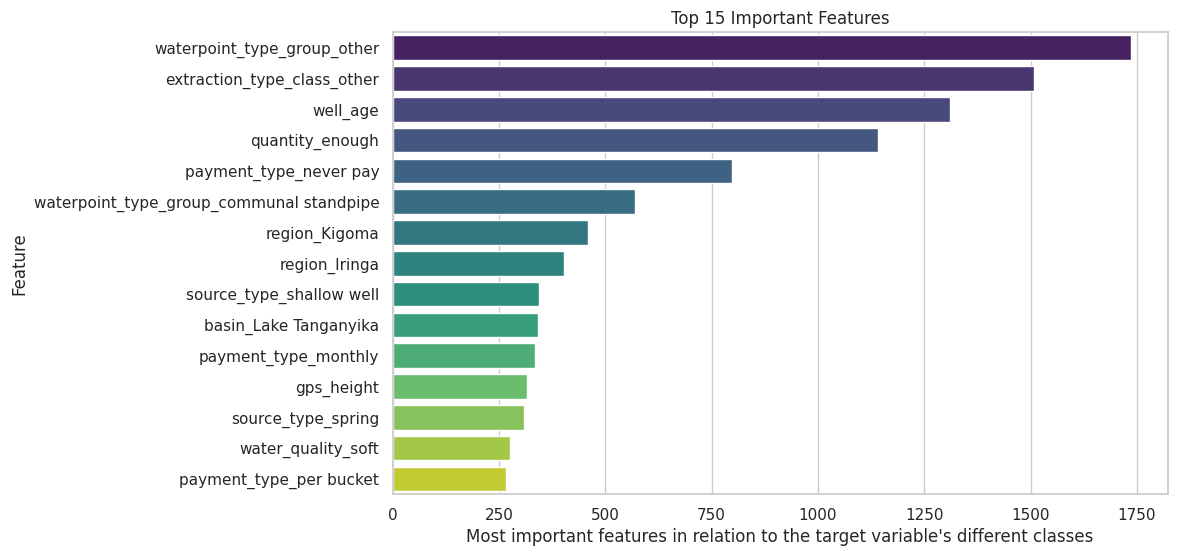

In [63]:


from sklearn.feature_selection import SelectKBest, f_classif
feature_names = X_train.columns.tolist()
scores, pvalues = f_classif(X_train, y_train)

feature_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort by Score in descending order and select top 15 features
top_features = feature_scores_df.sort_values(by='Score', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
plt.xlabel("Most important features in relation to the target variable's different classes")
plt.ylabel('Feature')
plt.title('Top 15 Important Features')

# Save plot to images folder
plt.savefig("./images/top-15-important-features.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

Per the top-15-important-features plot; it is evident that `water_point_type_group`, `extraction_type_class`, `well_age`, `quantity`, `payment_type`, `region`, `source_type`, `basin`, `water_quality`, and `gps_height` features are significant predictor features for a water well's functional status. Thus, the preprocessed train set is clean, appropriately balanced. and adequately inclusive of the most important features, for predicting the target variable.

## 5 Conclusion, and Recommendations

### 5.1 Conclusion

The analysis of the Tanzanian water well dataset demonstrates that supervised machine learning models can effectively predict the functional status of water wells using historical and engineered features. Through comprehensive data cleaning, feature engineering (notably the creation of the `well_age` variable), and careful handling of class imbalance, we ensured the dataset was robust for modeling.

Among the models evaluated, the hyperparameter-tuned Gradient Boosting Classifier consistently outperformed both Logistic Regression and Decision Tree models across all key metrics. The tuned Gradient Boosting model achieved the highest F1-score (0.74 on the train set and 0.72 on the test set), accuracy (0.71 train, 0.69 test), and ROC-AUC (0.89 train, 0.86 test), indicating strong predictive power and generalization to unseen data. Both untuned and tuned Logistic Regression models performed reasonably well, with F1-scores around 0.71 and accuracy near 73%, but were limited in capturing complex, non-linear relationships. Decision Tree models, while interpretable, showed a tendency to overfit and lagged behind in test set performance.

The ROC-AUC metric, which measures the model's ability to distinguish between the three well status classes, further confirmed the superiority of the tuned Gradient Boosting model. Its high ROC-AUC values reflect a strong ability to correctly rank wells by their likelihood of being functional, non-functional, or in need of repair.

In summary, the project confirms that with appropriate preprocessing, feature engineering, and model selection, machine learning can provide actionable insights for water well maintenance and resource allocation. The tuned Gradient Boosting Classifier is recommended for deployment due to its superior accuracy, balanced performance across classes, and robustness against overfitting.

### 5.2 Recommendations

The feature importance plot highlights that `water_point_type_group`, `extraction_type_class`, and `well_age` as the most influential predictors for a water-well's functional status. Other significant features include `quantity`, `payment_type`, `region`, `source_type`, `basin`, `gps_height`, and `water_quality`.

The `well_age` feature, which captures the difference between the year the well was recorded and its construction year, proved to be a critical factor (older wells are more likely to be non-functional or in need of repair). The type of water point and extraction method also play a substantial role, indicating that certain technologies or infrastructure types are more prone to failure. Regional and environmental factors, such as the well's location (`region`, `basin`) and water quality, further influence the likelihood of a well being functional.

Based on these findings, it is recommended that maintenance and resource allocation efforts prioritize wells that are older, utilize less reliable extraction types, or are located in regions with historically higher rates of non-functionality. Monitoring and proactive intervention for these high-risk wells can help improve water access and reduce downtime. Additionally, the importance of payment and management types suggests that community engagement and sustainable management practices may also contribute to better well functionality outcomes.

These insights provide actionable guidance for stakeholders aiming to optimize well maintenance schedules and target interventions where they are most needed, ultimately supporting more reliable access to clean water in Tanzania.

## 6 Next Steps

1. **Deploy the Tuned Gradient Boosting Classifier**: Given its superior performance, stakeholders should prioritize deploying the tuned Gradient Boosting model for ongoing prediction of water well status. This will enable proactive identification of wells at risk of failure or in need of repair.

2. **Integrate Model Predictions into Maintenance Planning**: Use the model’s predictions to inform and optimize maintenance schedules, prioritizing wells identified as high-risk based on key features such as well age, extraction type, and water point type group.

3. **Monitor and Update the Model Regularly**: As new data becomes available, retrain and validate the model to ensure its continued accuracy and relevance. This will help adapt to changing patterns in well functionality and environmental conditions.

4. **Collect and Incorporate Additional Data**: Encourage field teams to collect more granular data on well management, payment types, and environmental factors. Additional features may further improve model performance and provide deeper insights.

5. **Pilot Targeted Interventions**: Use the model to pilot targeted maintenance or resource allocation interventions in regions or for well types identified as high-risk, and measure the impact on well functionality and service delivery.